   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 71.1 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.5
    Uninstalling matplotlib-3.7.5:
      Successfully uninstalled matplotlib-3.7.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


<ipython-input-1-a932c75a1862>:233: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-1-a932c75a1862>:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xi, yi = int(x[i]), int(y[i])
<ipython-input-1-a932c75a1862>:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ti = int(t_normalized[i])
<ipython-input-1-a932c75a1862>:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecate

Image features shape: torch.Size([1, 64, 128, 128])
Event features shape: torch.Size([1, 64, 128, 128])
GPU memory allocated: 0.02 GiB
GPU memory reserved: 0.04 GiB
Image features shape: torch.Size([1, 64, 128, 128])
Event features shape: torch.Size([1, 64, 128, 128])
GPU memory allocated: 0.02 GiB
GPU memory reserved: 0.04 GiB
Image features shape: torch.Size([1, 64, 128, 128])
Event features shape: torch.Size([1, 64, 128, 128])
GPU memory allocated: 0.02 GiB
GPU memory reserved: 0.04 GiB
Image features shape: torch.Size([1, 64, 128, 128])
Event features shape: torch.Size([1, 64, 128, 128])
GPU memory allocated: 0.02 GiB
GPU memory reserved: 0.04 GiB
Image features shape: torch.Size([1, 64, 128, 128])
Event features shape: torch.Size([1, 64, 128, 128])
GPU memory allocated: 0.02 GiB
GPU memory reserved: 0.04 GiB
Image features shape: torch.Size([1, 64, 128, 128])
Event features shape: torch.Size([1, 64, 128, 128])
GPU memory allocated: 0.02 GiB
GPU memory reserved: 0.04 GiB
Image feat

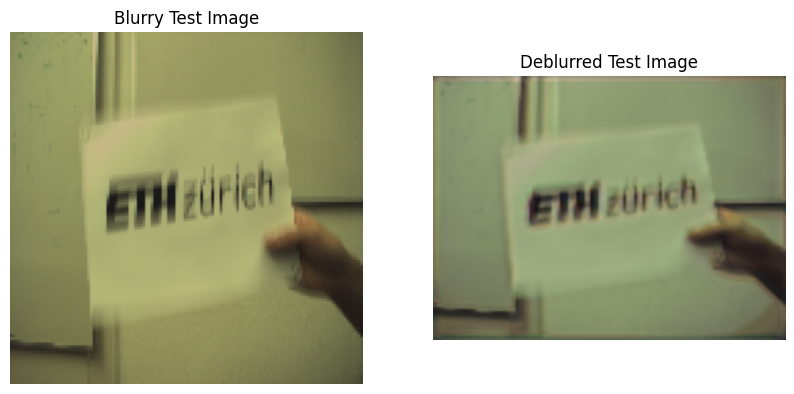

GPU memory allocated: 0.02 GiB
GPU memory reserved: 0.04 GiB
Image features shape: torch.Size([1, 64, 128, 128])
Event features shape: torch.Size([1, 64, 128, 128])
Processing test image logo_ethzurich_00029.png
deblurred_np shape: (128, 128, 3), dtype: float32, min: 0.05670166015625, max: 0.7587890625
deblurred_resized shape: (1224, 1632, 3)
deblurred_img shape before save: (1224, 1632, 3)
Saving deblurred test image to: /kaggle/working/test_output/logo_ethzurich_00029.png
Successfully saved /kaggle/working/test_output/logo_ethzurich_00029.png
Processing time for test image 2: 0.11 seconds
GPU memory allocated: 0.02 GiB
GPU memory reserved: 0.04 GiB
Image features shape: torch.Size([1, 64, 128, 128])
Event features shape: torch.Size([1, 64, 128, 128])
Processing test image logo_ethzurich_00041.png
deblurred_np shape: (128, 128, 3), dtype: float32, min: 0.02734375, max: 0.681640625
deblurred_resized shape: (1224, 1632, 3)
deblurred_img shape before save: (1224, 1632, 3)
Saving deblurre

In [1]:

!pip install torch torchvision scikit-image
!pip install --upgrade matplotlib

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import cv2
import matplotlib.pyplot as plt
import gc
import time

torch.cuda.empty_cache()
gc.collect()


def print_gpu_memory():
    if torch.cuda.is_available():
        print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GiB")
        print(f"GPU memory reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GiB")

def events_to_voxel_grid(x, y, timestamps, polarity, num_bins=10, height=128, width=128):
    voxel_grid = np.zeros((num_bins, height, width), dtype=np.float32)
    if timestamps.size > 0:
        t_min, t_max = timestamps.min(), timestamps.max()
        if t_max > t_min:
            t_normalized = (timestamps - t_min) / (t_max - t_min) * (num_bins - 1)
        else:
            t_normalized = np.zeros_like(timestamps)
        
        for i in range(len(x)):
            xi, yi = int(x[i]), int(y[i])
            ti = int(t_normalized[i])
            if 0 <= xi < width and 0 <= yi < height and 0 <= ti < num_bins:
                voxel_grid[ti, yi, xi] += polarity[i]
    return voxel_grid

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class CrossModalAttention(nn.Module):
    def __init__(self, channels):
        super(CrossModalAttention, self).__init__()
        self.query_conv = nn.Conv2d(channels, channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(channels, channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(channels, channels, kernel_size=1)
        self.softmax = nn.Softmax(dim=-1)
        self.disabled = False

    def forward(self, image_features, event_features):
        if self.disabled:
            print(f"CrossModalAttention disabled. Returning image_features: {image_features.shape}")
            return image_features
        batch, channels, height, width = image_features.size()
        print(f"Image features shape: {image_features.shape}")
        print(f"Event features shape: {event_features.shape}")
        
        query = self.query_conv(image_features)
        key = self.key_conv(event_features)
        value = self.value_conv(event_features)
        
        query = query.view(batch, -1, height * width)
        key = key.view(batch, -1, height * width)
        value = value.view(batch, -1, height * width)
        
        attention = self.softmax(torch.bmm(query.permute(0, 2, 1), key))
        out = torch.bmm(value, attention.permute(0, 2, 1)).view(batch, channels, height, width)
        return out + image_features

class EFNet(nn.Module):
    def __init__(self, in_channels=3, event_channels=10, out_channels=3):
        super(EFNet, self).__init__()
        self.image_conv = ConvBlock(in_channels, 64)
        self.event_conv = ConvBlock(event_channels, 64)
        self.attention = CrossModalAttention(64)
        self.res_blocks = nn.Sequential(
            ConvBlock(64, 64),
            ConvBlock(64, 64),
        )
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)

    def forward(self, blurry_image, event_data):
        image_features = self.image_conv(blurry_image)
        event_features = self.event_conv(event_data)
        fused_features = self.attention(image_features, event_features)
        features = self.res_blocks(fused_features)
        deblurred_image = self.final_conv(features)
        return deblurred_image

class HighREVDataset(Dataset):
    def __init__(self, data_dir, phase='train', target_size=(128, 128), num_bins=10):
        self.data_dir = os.path.join(data_dir, phase)
        self.blur_dir = os.path.join(self.data_dir, 'blur')
        self.sharp_dir = os.path.join(self.data_dir, 'sharp')
        self.event_dir = os.path.join(self.data_dir, 'event')
        self.target_size = target_size
        self.num_bins = num_bins
        
        self.blur_files = sorted(os.listdir(self.blur_dir))
        self.event_files = sorted(os.listdir(self.event_dir))
        
        self.file_map = {}
        for blur_file in self.blur_files:
            blur_base = os.path.splitext(blur_file)[0]
            for event_file in self.event_files:
                if blur_base in event_file:
                    self.file_map[blur_file] = event_file
                    break

    def __len__(self):
        return len(self.blur_files)

    def __getitem__(self, idx):
        blur_file = self.blur_files[idx]
        blur_path = os.path.join(self.blur_dir, blur_file)
        blur_img = cv2.imread(blur_path)
        if blur_img is None:
            raise FileNotFoundError(f"Could not load blur image: {blur_path}")
        original_height, original_width = blur_img.shape[:2]
        blur_img = cv2.cvtColor(blur_img, cv2.COLOR_BGR2RGB)
        blur_img = cv2.resize(blur_img, (self.target_size[1], self.target_size[0]))
        blur_img = blur_img.transpose(2, 0, 1) / 255.0
        blur_img = torch.FloatTensor(blur_img)

        sharp_path = os.path.join(self.sharp_dir, blur_file)
        sharp_img = cv2.imread(sharp_path)
        if sharp_img is None:
            raise FileNotFoundError(f"Could not load sharp image: {sharp_path}")
        sharp_img = cv2.cvtColor(sharp_img, cv2.COLOR_BGR2RGB)
        sharp_img = cv2.resize(sharp_img, (self.target_size[1], self.target_size[0]))
        sharp_img = sharp_img.transpose(2, 0, 1) / 255.0
        sharp_img = torch.FloatTensor(sharp_img)

        event_file = self.file_map[blur_file]
        event_path = os.path.join(self.event_dir, event_file)
        npz_data = np.load(event_path)
        x = npz_data['x']
        y = npz_data['y']
        timestamps = npz_data['timestamp']
        polarity = npz_data['polarity']
        
        original_height, original_width = cv2.imread(blur_path).shape[:2]
        x = (x / original_width) * self.target_size[1]
        y = (y / original_height) * self.target_size[0]
        
        event_data = events_to_voxel_grid(
            x, y, timestamps, polarity, self.num_bins, self.target_size[0], self.target_size[1]
        )
        if idx == 0:
            print(f"Event data shape: {event_data.shape}")
            print(f"Blurry image shape: {blur_img.shape}")
        event_data = torch.FloatTensor(event_data)

        return blur_img, event_data, sharp_img, blur_file, (int(original_width), int(original_height))


class HighREVTestDataset(Dataset):
    def __init__(self, data_dir, target_size=(128, 128), num_bins=10):
        self.data_dir = data_dir
        self.blur_dir = os.path.join(self.data_dir, 'blur')
        self.event_dir = os.path.join(self.data_dir, 'event')
        self.target_size = target_size
        self.num_bins = num_bins
        
        self.blur_files = sorted(os.listdir(self.blur_dir))
        self.event_files = sorted(os.listdir(self.event_dir))
        
        self.file_map = {}
        for blur_file in self.blur_files:
            blur_base = os.path.splitext(blur_file)[0]
            for event_file in self.event_files:
                if blur_base in event_file:
                    self.file_map[blur_file] = event_file
                    break

    def __len__(self):
        return len(self.blur_files)

    def __getitem__(self, idx):
        blur_file = self.blur_files[idx]
        blur_path = os.path.join(self.blur_dir, blur_file)
        blur_img = cv2.imread(blur_path)
        if blur_img is None:
            raise FileNotFoundError(f"Could not load blur image: {blur_path}")
        original_height, original_width = blur_img.shape[:2]
        blur_img = cv2.cvtColor(blur_img, cv2.COLOR_BGR2RGB)
        blur_img = cv2.resize(blur_img, (self.target_size[1], self.target_size[0]))
        blur_img = blur_img.transpose(2, 0, 1) / 255.0
        blur_img = torch.FloatTensor(blur_img)

        event_file = self.file_map[blur_file]
        event_path = os.path.join(self.event_dir, event_file)
        npz_data = np.load(event_path)
        x = npz_data['x']
        y = npz_data['y']
        timestamps = npz_data['timestamp']
        polarity = npz_data['polarity']
        
        original_height, original_width = cv2.imread(blur_path).shape[:2]
        x = (x / original_width) * self.target_size[1]
        y = (y / original_height) * self.target_size[0]
        
        event_data = events_to_voxel_grid(
            x, y, timestamps, polarity, self.num_bins, self.target_size[0], self.target_size[1]
        )
        if idx == 0:
            print(f"Test event data shape: {event_data.shape}")
            print(f"Test blurry image shape: {blur_img.shape}")
        event_data = torch.FloatTensor(event_data)

        return blur_img, event_data, blur_file, (int(original_width), int(original_height))


from torch.cuda.amp import GradScaler, autocast

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EFNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scaler = GradScaler()


train_dataset = HighREVDataset('/kaggle/input/highrev/HighREV', phase='train', target_size=(128, 128))
val_dataset = HighREVDataset('/kaggle/input/highrev/HighREV', phase='val', target_size=(128, 128))
test_dataset = HighREVTestDataset('/kaggle/input/highrev-testset/HighREV_test/HighREV_test', target_size=(128, 128))
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


num_epochs = 5  
accumulation_steps = 2
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    optimizer.zero_grad()
    for i, (blurry, events, sharp, _, _) in enumerate(train_loader):
        blurry, events, sharp = blurry.to(device), events.to(device), sharp.to(device)

        with torch.amp.autocast('cuda'):
            outputs = model(blurry, events)
            loss = criterion(outputs, sharp) / accumulation_steps
        
        scaler.scale(loss).backward()
        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            torch.cuda.empty_cache()
            gc.collect()
        else:
            torch.cuda.empty_cache()
            gc.collect()
        
        running_loss += loss.item() * accumulation_steps
        if i % (10 * accumulation_steps) == (10 * accumulation_steps - 1):
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/10:.4f}')
            running_loss = 0.0
        print_gpu_memory()


model.eval()
psnr_scores = []
ssim_scores = []
val_time = 0.0
print(f"Evaluating {len(val_loader)} validation images for metrics...")

with torch.no_grad():
    for i, (blurry, events, sharp, blur_filename, _) in enumerate(val_loader):
        start_time = time.time()
        blurry, events, sharp = blurry.to(device), events.to(device), sharp.to(device)
        with torch.amp.autocast('cuda'):
            deblurred = model(blurry, events)

        deblurred_np = deblurred.cpu().squeeze().permute(1, 2, 0).numpy().astype(np.float32)
        sharp_np = sharp.cpu().squeeze().permute(1, 2, 0).numpy().astype(np.float32)
        blurry_np = blurry.cpu().squeeze().permute(1, 2, 0).numpy().astype(np.float32)

        deblurred_np = np.clip(deblurred_np, 0, 1)
        sharp_np = np.clip(sharp_np, 0, 1)

        if deblurred_np.shape[0] < 7 or deblurred_np.shape[1] < 7:
            print(f"Warning: Validation image {blur_filename[0]} too small for SSIM")
            psnr_score = psnr(sharp_np, deblurred_np, data_range=1.0)
            ssim_score = 0
        else:
            psnr_score = psnr(sharp_np, deblurred_np, data_range=1.0)
            ssim_score = ssim(sharp_np, deblurred_np, data_range=1.0, multichannel=True, channel_axis=2)
        psnr_scores.append(psnr_score)
        ssim_scores.append(ssim_score)

        end_time = time.time()
        val_time += end_time - start_time

        del deblurred, blurry, events, sharp, deblurred_np, sharp_np, blurry_np
        torch.cuda.empty_cache()
        gc.collect()


total_time = 0.0
output_dir = '/kaggle/working/test_output'
os.makedirs(output_dir, exist_ok=True)
print(f"Processing {len(test_loader)} test images...")

with torch.no_grad():
    for i, (blurry, events, blur_filename, original_size) in enumerate(test_loader):
        start_time = time.time()
        blurry, events = blurry.to(device), events.to(device)
        with torch.amp.autocast('cuda'):
            deblurred = model(blurry, events)

        deblurred_np = deblurred.cpu().squeeze().permute(1, 2, 0).numpy().astype(np.float32)
        blurry_np = blurry.cpu().squeeze().permute(1, 2, 0).numpy().astype(np.float32)

        print(f"Processing test image {blur_filename[0]}")
        print(f"deblurred_np shape: {deblurred_np.shape}, dtype: {deblurred_np.dtype}, min: {deblurred_np.min()}, max: {deblurred_np.max()}")

        if deblurred_np.size == 0 or deblurred_np.shape[0] == 0 or deblurred_np.shape[1] == 0:
            print(f"Warning: Invalid deblurred_np for {blur_filename[0]}, skipping")
            continue

        deblurred_np = np.clip(deblurred_np, 0, 1)
        original_width = int(original_size[0])
        original_height = int(original_size[1])

        deblurred_resized = cv2.resize(deblurred_np, (original_width, original_height), interpolation=cv2.INTER_LINEAR)
        print(f"deblurred_resized shape: {deblurred_resized.shape}")
        deblurred_img = (deblurred_resized * 255).astype(np.uint8)
        print(f"deblurred_img shape before save: {deblurred_img.shape}")
        deblurred_img = cv2.cvtColor(deblurred_img, cv2.COLOR_RGB2BGR)  # Ensure RGB to BGR for cv2
        output_path = os.path.join(output_dir, blur_filename[0])
        print(f"Saving deblurred test image to: {output_path}")
        success = cv2.imwrite(output_path, deblurred_img, [cv2.IMWRITE_PNG_COMPRESSION, 0])  # No compression
        if not success:
            print(f"Failed to save {output_path}")
        else:
            print(f"Successfully saved {output_path}")

        end_time = time.time()
        processing_time = end_time - start_time
        total_time += processing_time
        print(f"Processing time for test image {i+1}: {processing_time:.2f} seconds")

        if i == 0:
            try:
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plt.title("Blurry Test Image")
                plt.imshow(blurry_np)
                plt.axis('off')
                plt.subplot(1, 2, 2)
                plt.title("Deblurred Test Image")
                plt.imshow(deblurred_resized)
                plt.axis('off')
                plt.show()
            except Exception as e:
                print(f"Error during visualization: {e}")

        del deblurred, blurry, events, deblurred_np, blurry_np, deblurred_resized, deblurred_img
        torch.cuda.empty_cache()
        gc.collect()
        print_gpu_memory()


avg_psnr = np.mean(psnr_scores) if psnr_scores else 0.0
avg_ssim = np.mean(ssim_scores) if ssim_scores else 0.0
avg_time_per_image = total_time / len(test_loader) if len(test_loader) > 0 else 0.0
avg_val_time_per_image = val_time / len(val_loader) if len(val_loader) > 0 else 0.0
print(f"Average PSNR (Validation): {avg_psnr:.2f}")
print(f"Average SSIM (Validation): {avg_ssim:.4f}")
print(f"Average runtime per test image: {avg_time_per_image:.2f} seconds")

device_type = 0 if torch.cuda.is_available() and device.type == 'cuda' else 1
extra_data = 0


readme_content = f"""runtime per image [s] : {avg_time_per_image:.2f}
CPU[1] / GPU[0] : {device_type}
Extra Data [1] / No Extra Data [0] : {extra_data}
Average PSNR (Validation) : {avg_psnr:.2f}
Average SSIM (Validation) : {avg_ssim:.4f}
Other description : Solution based on a custom EFNet model implemented in PyTorch, leveraging event-based data for deblurring. The model uses CrossModalAttention for feature fusion and was trained for 5 epochs on the HighREV training dataset to optimize PSNR within Kaggle time limits. This implementation runs on Kaggle with GPU acceleration when available. Dependencies include PyTorch, torchvision, scikit-image, and cv2 (OpenCV). Deblurred test images are saved in /kaggle/working/test_output as full-quality RGB PNGs at original resolution (1632x1224) with no compression (level 0) to preserve true quality and detail. Metrics (PSNR, SSIM) are computed on the validation set.
"""
readme_path = os.path.join(output_dir, 'readme.txt')
with open(readme_path, 'w') as f:
    f.write(readme_content)

print(f"readme.txt created at: {readme_path}")
print(f"readme.txt content:\n{readme_content}")
print(f"Deblurred test images saved in: {output_dir}")
print("Check the Kaggle output section under '/kaggle/working/test_output' for images and readme.txt")